In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from NeuralAdversarialBalancing import NeuralAdversarialBalancing as NAB

%matplotlib inline

## Generate synthetic data

In [2]:
n = 500
m = 500
xi = torch.normal(mean = -1, std = 3, size = (n,1))
xi_ring = torch.zeros(size = (m,1))
for i in range(m):
    if torch.rand(1).item()>0.3:
        xi_ring[i,0] = torch.normal(mean = -4, std = 2, size = (1,)).item()
    else:
        xi_ring[i,0] = torch.normal(mean = 3, std = 0.2, size = (1,)).item()

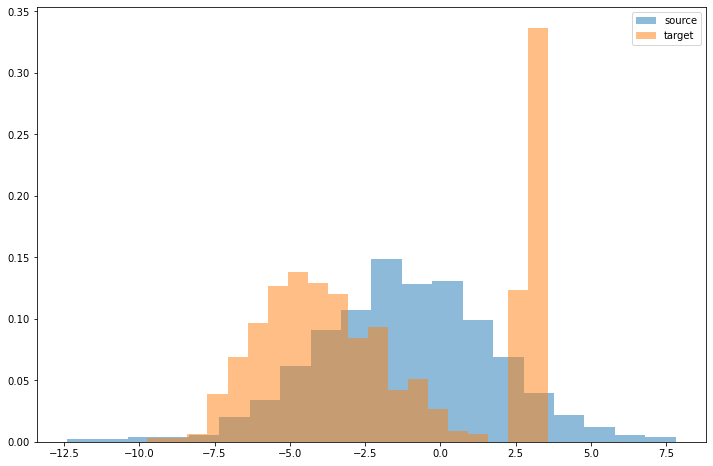

In [3]:
plt.figure(figsize = (12,8))
plt.hist(xi[:,0].to("cpu").detach().numpy(), alpha = 0.5, bins = 20, label ="source", density = True)
plt.hist(xi_ring[:,0].to("cpu").detach().numpy(), alpha = 0.5, bins = 20, label ="target", density = True)
plt.legend()

## Build Adversarial_Balancing class

In [4]:
AB = NAB(xi,xi_ring)

## Build Neural Networks

We consider two densely connected ReLU networks with 1 hidden layer. 

Note that the IPM models requires double amounts of nodes in order to ensure a $L^2$ control of the associated Riesz representers by Neural-IPM. 

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self,input_dim = 1, num_nodes = 32):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, num_nodes),
            nn.ReLU(),
            nn.Linear(num_nodes, num_nodes),
            nn.ReLU(),
            nn.Linear(num_nodes, 1),
        )

    def forward(self, x):
        x = self.flatten(x)
        target = self.linear_relu_stack(x)
        return target

In [6]:
num_nodes_IPM = 32
model_IPM = NeuralNetwork(num_nodes = 2*num_nodes_IPM).to(AB.dev)
model_reweighting = NeuralNetwork(num_nodes = num_nodes_IPM).to(AB.dev)

### Build optimizers

In [7]:
learning_rate = 0.001
optimizer_IPM = torch.optim.Adam(model_IPM.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=True)
optimizer_reweighting = torch.optim.Adam(model_reweighting.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=True)

## Play the game

In [8]:
epochs = 5000
loss_trace = []
# warming up
for t in tqdm(range(epochs)):
    current_test_loss = AB.train_loop(model_IPM = model_IPM,
                                      model_reweighting = model_reweighting,
                                      optimizer_IPM = optimizer_IPM,
                                      optimizer_reweighting = optimizer_reweighting,
                                      IPM_steps = 3,
                                      reweight_steps = 3,
                                      lambda_l2_weight = 1e2,
                                      lambda_l2_IPM = 1e-3,)
    loss_trace.append(current_test_loss.to("cpu").detach().numpy())

print("Done!")

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:03<00:00, 40.62it/s]

Done!


Text(0.5, 1.0, 'Gaming curve between the two players')

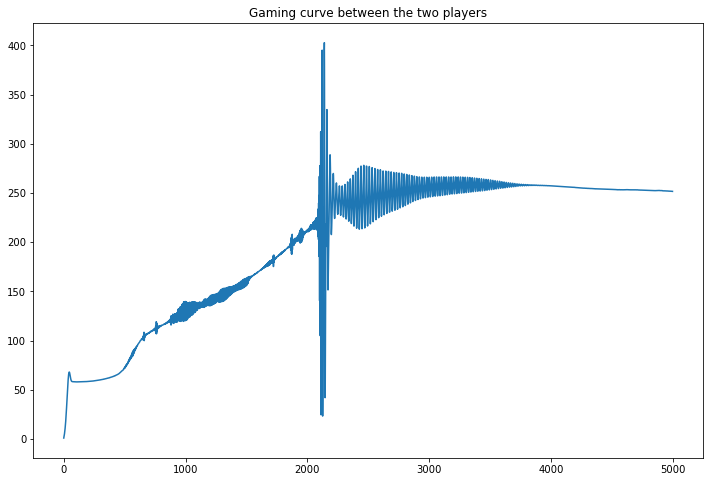

In [9]:
plt.figure(figsize = (12,8))
plt.plot(np.array(loss_trace))
plt.title("Gaming curve between the two players")

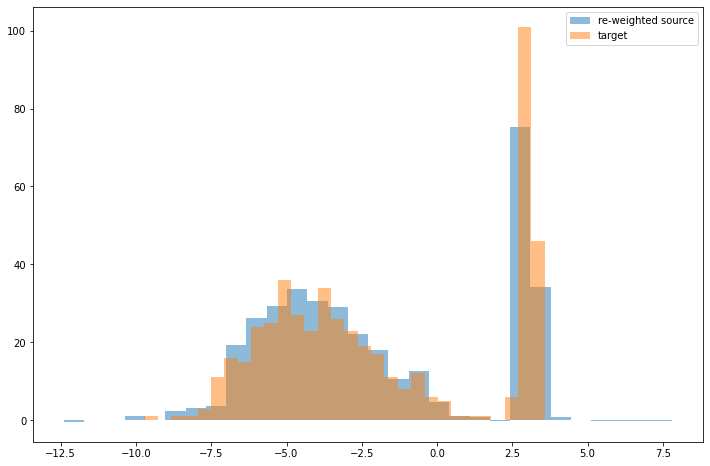

In [10]:
plt.figure(figsize = (12,8))
plt.hist(AB.xi[:,0].to("cpu").detach().numpy(), weights = model_reweighting(AB.xi).to("cpu").detach().numpy(), alpha = 0.5, bins = 30, label ="re-weighted source")
plt.hist(AB.xi_ring[:,0].to("cpu").detach().numpy(), alpha = 0.5, bins = 30, label ="target")
plt.legend()

In [11]:
model_reweighting(AB.xi).mean()

tensor(0.7148, device='cuda:0', grad_fn=<MeanBackward0>)